In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import pandas as pd

In [2]:
def calculate_weighted_average(
    means: np.ndarray, 
    stds: np.ndarray
):
    """
    Calculates the weighted average and its associated standard deviation 
    (standard error of the weighted mean) from a set of independent 
    measurements, where each measurement has its own uncertainty.

    The method uses inverse-variance weighting, where the weight is 
    inversely proportional to the square of the standard deviation (variance).

    Args:
        means: A NumPy array of the measurement values (x_i).
        stds: A NumPy array of the standard deviations (uncertainties, sigma_i) 
              associated with each measurement. Must be the same length as means.

    Returns:
        A tuple containing:
        - The weighted average (float, x_bar).
        - The standard deviation of the weighted average (float, sigma_x_bar).

    Raises:
        ValueError: If means and stds arrays are not the same length, or if 
                    any standard deviation is zero or negative.
    """
    if isinstance(means, list):
        means = np.array(means)
    if isinstance(stds, list):
        stds = np.array(stds)
    if means.shape != stds.shape:
        raise ValueError("The 'means' and 'stds' arrays must have the same shape.")

    if np.any(stds <= 0):
        raise ValueError("Standard deviations (stds) must be positive values (> 0).")

    # 1. Calculate the weights (w_i = 1 / sigma_i^2)
    # The weight is the inverse of the variance. This ensures that more precise
    # measurements (smaller sigma_i) have a higher weight.
    weights = 1.0 / (stds ** 2)

    # 2. Calculate the Weighted Mean (x_bar)
    # np.average handles the calculation: sum(x_i * w_i) / sum(w_i)
    weighted_average = np.average(means, weights=weights)

    # 3. Calculate the Standard Deviation of the Weighted Mean (sigma_x_bar)
    # The variance of the weighted mean is given by the reciprocal of the 
    # sum of the weights (sum of inverse variances).
    # Var(x_bar) = 1 / sum(w_i)
    # sigma_x_bar = sqrt(Var(x_bar))
    variance_x_bar = 1.0 / np.sum(weights)
    std_of_average = np.sqrt(variance_x_bar)

    return weighted_average, std_of_average

In [3]:
def harmonic_mean(a, b):
    return 2 * a * b / (a + b)

In [69]:
root = '/WorkSpace-2/csamplawski/src/BayesAdapt/logs'
model_family = 'Qwen'
models = ["Qwen2.5-0.5B","Qwen2.5-1.5B","Qwen2.5-3B","Qwen2.5-7B","Qwen2.5-14B"]
model_sizes = np.array([0.5, 1.5, 3, 7, 14])
datasets = ['winogrande_s', 'winogrande_m', 'ARC-Easy', 'ARC-Challenge', 'obqa', 'boolq']
colors = ['red', 'blue', 'green', 'orange']
line_styles = ['-', 'dashed', 'dotted', '--']

seeds = [0, 1, 2, 3]
MODEL_SIZES = {
    "Qwen2.5-0.5B": 0.5,
    "Qwen2.5-1.5B": 1.5,
    "Qwen2.5-3B": 3.0,
    "Qwen2.5-7B": 7.0,
    "Qwen2.5-14B": 14.0
}
wrappers = ['scalabl', 'zeroshot', 'mle', 'blob']
results = []
verbose = False
for wrapper in wrappers:
    for dataset in datasets:
        for model in models:
            for seed in seeds:
                logdir = f'{root}/{model_family}/{model}/{wrapper}/{dataset}/seed{seed}'
                result_fname = f'{logdir}/results.json'
                try:
                    with open(result_fname, 'r') as f:
                        metrics_list = json.load(f)
                except:
                    if verbose:
                        print(f'{result_fname} not found')
                    continue

                
                for i, metric_dict in enumerate(metrics_list):
                    record = {
                        "wrapper": wrapper,
                        "dataset": dataset,
                        "model": model,
                        "model_size": MODEL_SIZES.get(model),
                        'train_seed': seed,
                    }
                    for key, val in metric_dict.items():
                        if isinstance(val, dict):
                            record[key] = val['mean']
                        else:
                            if key == 'seed':
                                record['test_seed'] = val
                            else:
                                record[key] = val
                    results.append(record)
df = pd.DataFrame(results)
df['calibrated_acc'] = harmonic_mean(df['test_acc'], 1 - df['test_ece'])

     wrapper  model_size      mean       std
0       blob         0.5  0.421474  0.009766
1       blob         1.5  0.492480  0.004675
2       blob         3.0  0.620170  0.003317
3       blob         7.0  0.488881  0.023446
4       blob        14.0  0.818281  0.010696
5        mle         0.5  0.031791       NaN
6        mle         1.5  0.032653       NaN
7        mle         3.0  0.042624       NaN
8        mle         7.0  0.041844       NaN
9        mle        14.0  0.063723       NaN
10   scalabl         0.5  0.357325  0.001522
11   scalabl         1.5  0.415792  0.002844
12   scalabl         3.0  0.533749  0.002018
13   scalabl         7.0  0.423893  0.001070
14   scalabl        14.0  0.717574  0.004085
15  zeroshot         0.5  0.022512       NaN
16  zeroshot         1.5  0.027512       NaN
17  zeroshot         3.0  0.035137       NaN
18  zeroshot         7.0  0.030966       NaN
19  zeroshot        14.0  0.050626       NaN


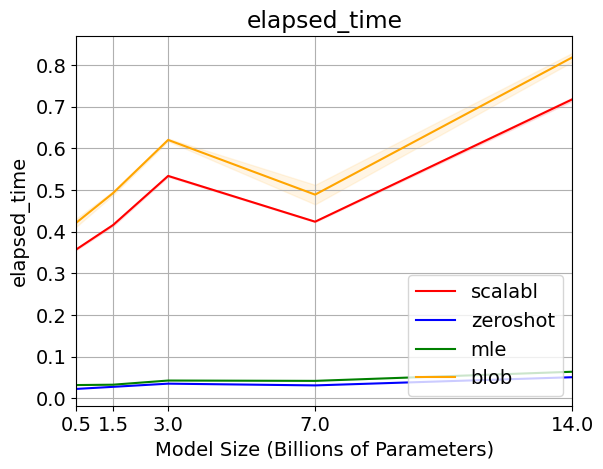

In [59]:
metric = 'elapsed_time'
plot_df = df.query("train_seed == 0 and dataset == 'winogrande_s'")
plot_df = plot_df.groupby(['wrapper', 'model_size'])[metric]
plot_df = plot_df.agg(mean='mean', std='std').reset_index()
print(plot_df)
for i, wrapper in enumerate(wrappers):
    vals = plot_df[plot_df['wrapper'] == wrapper]
    num_points = len(vals)
    plt.plot(
        model_sizes[0:num_points], 
        vals['mean'], 
        color=colors[i], 
        label=wrapper,
        #linestyle='dotted'
    )
    plt.fill_between(
        model_sizes[0:num_points],
        vals['mean'] - vals['std'],
        vals['mean'] + vals['std'],
        color=colors[i],
        alpha=0.1,  # Transparency is set to 20%
    )
plt.grid()
plt.xticks(model_sizes);
plt.xlabel('Model Size (Billions of Parameters)')
plt.xlim(min(model_sizes), max(model_sizes))
plt.ylabel(metric)
plt.title(metric)
plt.legend()

    wrapper  model_size      mean       std
7   scalabl         0.5  0.529730  0.010994
8   scalabl         1.5  0.793919  0.010961
9   scalabl         3.0  0.838007  0.007144
10  scalabl         7.0  0.904054  0.006522
11  scalabl        14.0  0.922466  0.007227
     wrapper  model_size      mean  std
12  zeroshot         0.5  0.253378  NaN
13  zeroshot         1.5  0.287162  NaN
14  zeroshot         3.0  0.739865  NaN
15  zeroshot         7.0  0.770270  NaN
16  zeroshot        14.0  0.844595  NaN
  wrapper  model_size      mean       std
2     mle         0.5  0.565878  0.011944
3     mle         1.5  0.780405  0.004778
4     mle         3.0  0.812500  0.026278
5     mle         7.0  0.891892  0.004778
6     mle        14.0  0.918919  0.009555
  wrapper  model_size      mean       std
0    blob         0.5  0.517230  0.013556
1    blob         1.5  0.790203  0.010498


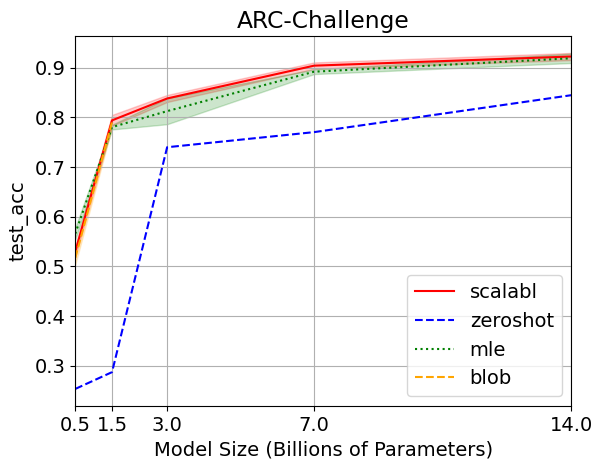

In [71]:
metric = 'test_acc'
dataset = 'ARC-Challenge'
plot_df = df.query(f"dataset == '{dataset}'")
plot_df = plot_df.groupby(['wrapper', 'model_size'])[metric]
plot_df = plot_df.agg(mean='mean', std='std').reset_index()

plt.rcParams['font.size'] = 14
for i, wrapper in enumerate(wrappers):
    vals = plot_df[plot_df['wrapper'] == wrapper]
    print(vals)
    num_points = len(vals)
    plt.plot(
        model_sizes[0:num_points], vals['mean'], 
        color=colors[i], 
        label=wrapper,
        linestyle=line_styles[i]
    )
    plt.fill_between(
        model_sizes[0:num_points],
        vals['mean'] - vals['std'],
        vals['mean'] + vals['std'],
        color=colors[i],
        alpha=0.2,  # Transparency is set to 20%
    )
plt.grid()
plt.xticks(model_sizes);
plt.xlabel('Model Size (Billions of Parameters)')
plt.xlim(min(model_sizes), max(model_sizes))
plt.ylabel(metric)
plt.title(dataset)
plt.legend()
#plt.ylim(0,1)

In [ ]:

sns.lineplot(
    data=plot_df,
    x='model_size',          # X-axis
    y='mean',            # Y-axis
    hue='wrapper',           # Create separate lines for each wrapper
    style='wrapper',         # Use different line styles (e.g., solid, dashed)
    marker='o',              # Add markers to the data points
    errorbar='sd'            # THIS IS THE KEY: 'sd' = plot the standard deviation
)
plt.grid()

In [ ]:
dataset = 'winogrande_s'

y, y_std = [], []
for wrapper in wrappers:
    for model_size in MODEL_SIZES.values():
        query = f"wrapper == '{wrapper}' and dataset == '{dataset}' and model_size == {model_size}"
        vals = df.query(query_template.format(wrapper='scalabl', dataset='winogrande_s', model_size=0.5))
        y.append(vals[metric].mean())
        y_std.append(vals[metric].std())
y = vals['test_acc']
y.mean(), y.std()

In [ ]:
df[df['model_size'] == 0.5]['peak_memory'].describe()

In [ ]:
dataset = 'winogrande_s'
wrapper = 'scalabl'


In [ ]:
results['boolq']

In [ ]:
def compute_y_with_std(metric):
    Y, Y_STD = [], []
    for model in models:
        y, y_std = [], []
        for dataset in datasets:
            vals = [e[metric] for e in results[dataset][model]]
            means = np.array([e[metric]['mean'] for e in results[dataset][model]])
            stds = np.array([e[metric]['std'] for e in results[dataset][model]])
            #mean, std = calculate_weighted_average(means, stds)
            y.extend(means)
            y_std.extend(stds)
        #y has len = len(datasets)
        #y, y_std = calculate_weighted_average(y, y_std)
        Y.append(y)
        Y_STD.append(y_std)
    return np.array(Y), np.array(Y_STD)
    
time_mean, time_std = compute_y_with_std('elapsed_time')
peak_mem_mean, peak_mem_std = compute_y_with_std('peak_memory')

In [ ]:
model_sizes

In [ ]:
def compute_y(dataset, metric):
    y, y_std = [], []
    for model in models:
        vals = [e[metric] for e in results[dataset][model]]
        print(dataset, model, len(vals))
        y.append(np.mean(vals))
        y_std.append(np.std(vals))
    y = np.array(y)
    y_std = np.array(y_std)
    return y, y_std

In [ ]:
metric = 'test_nll'

color = 'blue'
dataset = 'ARC-Easy'
y, y_std = compute_y(dataset, metric)
#y, y_std = np.mean(peak_mem_mean, axis=1), np.std(peak_mem_mean, axis=1)
#y, y_std = compute_y_with_std(metric)
plt.plot(model_sizes, y, color=color, label=dataset)
plt.fill_between(
    model_sizes,
    y - y_std,
    y + y_std,
    color=color,
    alpha=0.1,  # Transparency is set to 20%
)




plt.ylabel(metric)
plt.grid()
plt.xticks(model_sizes)
plt.xlim(min(model_sizes), max(model_sizes))
plt.title(f'{dataset} | {metric}')
plt.xlabel('Model Size (Billions of Parameters)')
plt.legend()
plt.ylim(0)
#plt.ylim(0,5)
#plt.ylim(0,3)

In [ ]:
color = 'red'
dataset = 'obqa'
#y, y_std = compute_y(dataset, metric)
y, y_std = compute_y_with_std(dataset, metric)
plt.plot(model_sizes, y, color=color, label=dataset)
plt.fill_between(
    model_sizes,
    y - y_std,
    y + y_std,
    color=color,
    alpha=0.1,  # Transparency is set to 20%
)

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(results).T
df

In [ ]:
df['elapsed_time']

In [ ]:
calib_acc = harmonic_mean(df['test_acc'], 1-df['test_ece'])
#plt.plot(model_sizes, calib_acc, label='Calibrated Acc')
plt.plot(model_sizes, df['test_ece'], label='ECE')
#plt.plot(model_sizes, df['test_ece'])
plt.grid()
plt.legend()
plt.xlabel('Model Size (Billions of Parameters)')
plt.ylabel('Metric Value')
plt.xticks(model_sizes)
plt.ylim(0,1)
plt.xlim(min(model_sizes), max(model_sizes))
plt.title(f'{dataset}')

In [ ]:
calib_acc = harmonic_mean(df['test_acc'], 1-df['test_ece'])
#plt.plot(model_sizes, calib_acc, label='Calibrated Acc')
plt.plot(model_sizes, df['test_acc'], label='Acc')
#plt.plot(model_sizes, df['test_ece'])
plt.grid()
plt.legend()
plt.xlabel('Model Size (Billions of Parameters)')
plt.ylabel('Metric Value')
plt.xticks(model_sizes)
plt.ylim(0,1)
plt.xlim(min(model_sizes), max(model_sizes))
plt.title(f'{dataset}')

In [ ]:
#calib_acc = harmonic_mean(df['test_acc'], 1-df['test_ece'])
#plt.plot(model_sizes, calib_acc, label='Calibrated Acc')
plt.plot(model_sizes, df['test_nll'], label='NLL')
#plt.plot(model_sizes, df['test_ece'])
plt.grid()
plt.legend()
plt.xlabel('Model Size (Billions of Parameters)')
plt.ylabel('NLL')
plt.xticks(model_sizes)
#plt.ylim(0,1)
plt.xlim(min(model_sizes), max(model_sizes))
plt.title(f'{dataset}')

In [ ]:
acc_vals = np.linspace(1e-8,1,100)
ece_vals = np.linspace(1e-8,1,100)
#cal_acc = harmonic_mean(acc_vals, 1-ece_vals)
A, B = np.meshgrid(acc_vals, 1-ece_vals)

# 2. Calculate the corresponding 'y' (Z-axis) values
Y = harmonic_mean(A, B)

# 3. Plotting Setup
fig = plt.figure(figsize=(10, 7))

# Create a 3D subplot projection
ax = fig.add_subplot(111, projection='3d')

# 4. Create the surface plot
# The 'cmap' (color map) determines the coloring scheme.
surface = ax.plot_surface(
    A, B, Y, 
    cmap='viridis', 
    edgecolor='none'
)
